In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the dataset (replace with your actual file path)
#df = pd.read_csv('data/2024-06-01_2024-09-01/aggregated/percent_return.csv')
#df = pd.read_csv('data/2024-08-20_2024-08-28/aggregated/percent_return.csv')
df = pd.read_csv('data/2023-09-01_2024-09-01/aggregated/percent_return.csv') # 1 year's worth of data

# Extract stock names
stock_names = df.columns[1:]  # Assuming the first column is the date

print(df) #every 5th row is a friday

           date             A          AAPL          ABBV          ABNB  \
0    2023-09-01  6.955830e+05  2.428850e+07  2.371953e+06  3.329691e+06   
1    2023-09-05  1.079488e+06  2.401770e+07  2.802535e+06  1.479560e+07   
2    2023-09-06  1.427409e+06  4.497533e+07  3.813672e+06  5.018169e+06   
3    2023-09-07  1.142687e+06  6.374670e+07  3.615118e+06  5.533647e+06   
4    2023-09-08  1.583872e+06  3.701821e+07  3.048799e+06  6.395867e+06   
..          ...           ...           ...           ...           ...   
246  2024-08-26  7.222382e+05  1.348518e+07  2.135079e+06  4.276281e+06   
247  2024-08-27  6.740402e+05  1.577595e+07  1.288436e+06  2.961524e+06   
248  2024-08-28  7.737799e+05  1.681921e+07  2.017006e+06  2.946977e+06   
249  2024-08-29  1.108376e+06  2.261333e+07  2.343655e+06  2.856675e+06   
250  2024-08-30  1.100656e+06  2.316545e+07  1.961752e+06  2.795314e+06   

              ABT          ACGL            ACN           ADBE           ADI  \
0    2.633559e+06  1

In [72]:
# Prepare the data for Monday to Thursday (features) and Friday (target)
X = []
y = []

# Iterate over the dataset in chunks of 5 rows (representing one week)
for i in range(0, len(df), 5):
    if i + 4 >= len(df):  # Prevent going out of bounds
        break
    # Monday to Thursday data (features)
    X.extend(df.iloc[i:i+4, 1:].T.values.tolist()) # rows are companies
    #X += df.iloc[i:i+4, 1:].T.values
    # Friday data (target)
    y.extend(df.iloc[i+4, 1:].T.values.tolist())  # Friday returns as target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np

# Define the parameter distributions
param_dist = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    'gamma': [0, 2, 4, 6, 8, 10],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_delta_step': [0, 2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 1, 2, 5, 10],  # L1 regularization
    'lambda': [1, 2, 4, 6, 8, 10],  # Adjusted L2 regularization
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    scoring='r2',  # Optimize for R^2 score
    cv=TimeSeriesSplit(n_splits=5),  # 5-fold cross-validation, with time series(stock data)
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Output best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)

Best Parameters: {'subsample': 0.5, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'max_delta_step': 0, 'learning_rate': 0.03, 'lambda': 6, 'gamma': 4, 'alpha': 2}
Best R^2 Score: 0.8270723098883848


In [74]:
from sklearn.dummy import DummyRegressor

# Baseline model that predicts the mean y for all feature values
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)

In [75]:
# Calculate R^2 scores
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
print("Cross-Validation Scores (Training Data):", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))

# Evaluate on test set
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test R^2 Score:", test_r2)

baseline_r2 = r2_score(y_test, baseline_predictions) # should be 0, since it predicts the mean
print(f"Baseline R^2 Score: {baseline_r2}")


Cross-Validation Scores (Training Data): [0.80517942 0.81093799 0.8277384  0.8355671  0.85593863]
Mean CV R^2 Score: 0.8270723098883848
Test R^2 Score: 0.7123441066401548
Baseline R^2 Score: -0.00013655132404921666


In [76]:
### Model evaluation
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse}")

# Calculate RMSE for baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE:", baseline_rmse)
print("Model Improvement:", baseline_rmse - rmse)

Model RMSE: 32357055.830322072
Baseline RMSE: 60333984.856081285
Model Improvement: 27976929.025759213


In [77]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Calculate Baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model Improvement: {baseline_rmse - rmse:.2f}")

# Normalized RMSE (by range)
nrmse = rmse / (y_test.max() - y_test.min())
print(f"Normalized RMSE (Range): {nrmse:.2%}")

# Normalized RMSE (by mean)
nrmse_mean = rmse / y_test.mean()
print(f"Normalized RMSE (Mean): {nrmse_mean:.2%}")

# Daily change standard deviation
daily_changes = np.diff(y_test).std()
print(f"Daily Change Std Dev: {daily_changes:.2f}")

Model RMSE: 32357055.83
Baseline RMSE: 60333984.86
Model Improvement: 27976929.03
Normalized RMSE (Range): 1.35%
Normalized RMSE (Mean): 251.62%
Daily Change Std Dev: 85776819.76


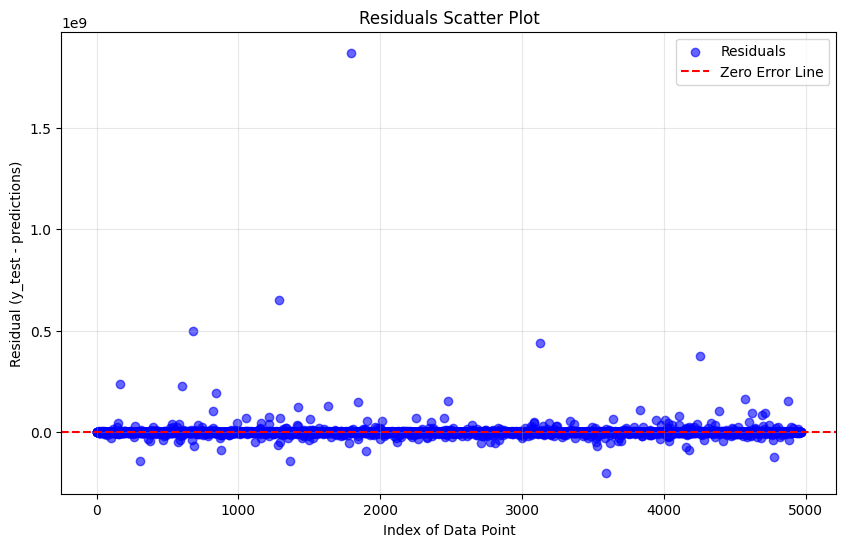

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Residuals (errors for each prediction)
residuals = y_test - predictions

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('Residual (y_test - predictions)')
plt.title('Residuals Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


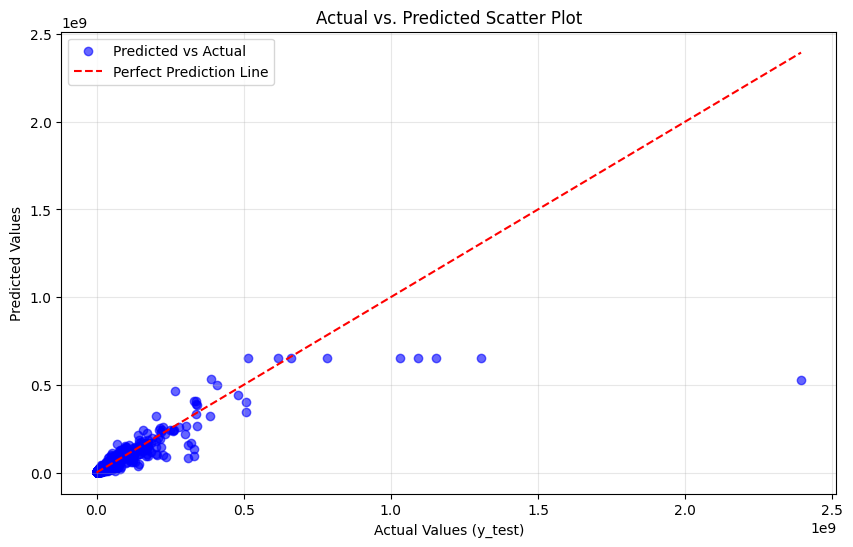

In [79]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')

# Labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


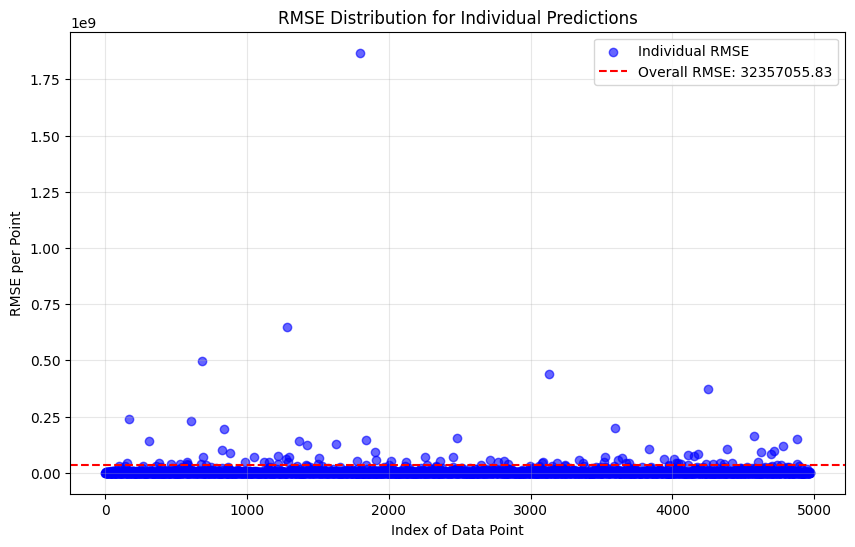

In [80]:
# Calculate individual RMSE values (absolute errors)
individual_rmse = np.sqrt((y_test - predictions) ** 2)

# Scatter plot of individual RMSE values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(individual_rmse)), individual_rmse, alpha=0.6, color='blue', label='Individual RMSE')
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Overall RMSE: {rmse:.2f}')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('RMSE per Point')
plt.title('RMSE Distribution for Individual Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()
